# 2. Baseline Model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve
)

import lightgbm as lgb

#Sabitler
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Veri Hazirlama

In [3]:
# Veri yolu
DATA_PATH = Path('../data/raw/')

# Veriyi yukle
df = pd.read_csv(DATA_PATH / 'bank.csv')

# Temel bilgiler
print(f'Veri yuklendi!')
print(f'Satir sayisi: {df.shape[0]:,}')
print(f'Sutun sayisi: {df.shape[1]}')
print(f'\nTarget dagilimi:')
print(df['deposit'].value_counts())

Veri yuklendi!
Satir sayisi: 11,162
Sutun sayisi: 17

Target dagilimi:
deposit
no     5873
yes    5289
Name: count, dtype: int64


## 2. Basit Preprocessing

In [4]:
# Target ve Feature'lari ayir
TARGET = 'deposit'

# Target'i numerik yap (yes=1, no=0)
y = (df[TARGET] == 'yes').astype(int)

# Feature'lari al (target haric)
X = df.drop(columns=[TARGET])

print(f'Features (X): {X.shape}')
print(f'Target (y): {y.shape}')
print(f'\nTarget dagilimi:')
print(f'  0 (No):  {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)')
print(f'  1 (Yes): {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)')

Features (X): (11162, 16)
Target (y): (11162,)

Target dagilimi:
  0 (No):  5,873 (52.6%)
  1 (Yes): 5,289 (47.4%)


In [5]:
# Kategorik ve numerik sutunlari belirle
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f'Kategorik sutunlar ({len(cat_cols)}): {cat_cols}')
print(f'Numerik sutunlar ({len(num_cols)}): {num_cols}')

Kategorik sutunlar (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerik sutunlar (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [6]:
# Label Encoding uygula
X_encoded = X.copy()

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le
    print(f'{col}: {len(le.classes_)} kategori -> {list(le.classes_)[:5]}...')

print(f'\nEncoding tamamlandi!')
print(f'X_encoded shape: {X_encoded.shape}')
print(f'Veri tipleri:\n{X_encoded.dtypes.value_counts()}')

job: 12 kategori -> ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management']...
marital: 3 kategori -> ['divorced', 'married', 'single']...
education: 4 kategori -> ['primary', 'secondary', 'tertiary', 'unknown']...
default: 2 kategori -> ['no', 'yes']...
housing: 2 kategori -> ['no', 'yes']...
loan: 2 kategori -> ['no', 'yes']...
contact: 3 kategori -> ['cellular', 'telephone', 'unknown']...
month: 12 kategori -> ['apr', 'aug', 'dec', 'feb', 'jan']...
poutcome: 4 kategori -> ['failure', 'other', 'success', 'unknown']...

Encoding tamamlandi!
X_encoded shape: (11162, 16)
Veri tipleri:
int64    16
Name: count, dtype: int64


In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Target dagilimini korur
)

print(f'Train set: {X_train.shape[0]:,} ornek')
print(f'Test set:  {X_test.shape[0]:,} ornek')
print(f'\nTrain target dagilimi:')
print(f'  0: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)')
print(f'  1: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)')
print(f'\nTest target dagilimi:')
print(f'  0: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)')
print(f'  1: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%)')

Train set: 8,929 ornek
Test set:  2,233 ornek

Train target dagilimi:
  0: 4,698 (52.6%)
  1: 4,231 (47.4%)

Test target dagilimi:
  0: 1,175 (52.6%)
  1: 1,058 (47.4%)


In [8]:
# Cross-Validation ayarlari
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# LightGBM Baseline Model (default parametreler)
lgbm_baseline = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation skorlari
print('5-Fold Cross-Validation basladi...\n')
cv_scores = cross_val_score(
    lgbm_baseline, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print('Fold skorlari:')
for i, score in enumerate(cv_scores, 1):
    print(f'  Fold {i}: {score:.4f}')

print(f'\nOrtalama AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')

5-Fold Cross-Validation basladi...

Fold skorlari:
  Fold 1: 0.9177
  Fold 2: 0.9343
  Fold 3: 0.9247
  Fold 4: 0.9222
  Fold 5: 0.9208

Ortalama AUC: 0.9239 (+/- 0.0056)


In [10]:
# Modeli tum train seti ile egit
print('Model tum train seti ile egitiliyor...')
lgbm_baseline.fit(X_train, y_train)

# Test seti tahminleri
y_pred = lgbm_baseline.predict(X_test)
y_pred_proba = lgbm_baseline.predict_proba(X_test)[:, 1]

# Metrikler
test_auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print('\n=== TEST SETI METRIKLERI ===')
print(f'AUC:       {test_auc:.4f}')
print(f'Accuracy:  {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall:    {test_recall:.4f}')
print(f'F1 Score:  {test_f1:.4f}')

Model tum train seti ile egitiliyor...

=== TEST SETI METRIKLERI ===
AUC:       0.9259
Accuracy:  0.8607
Precision: 0.8297
Recall:    0.8885
F1 Score:  0.8581


=== TOP 10 FEATURE IMPORTANCE ===
 feature  importance
   month         501
duration         491
     day         419
 balance         339
     age         296
   pdays         252
campaign         124
 contact         112
     job         107
 housing          88


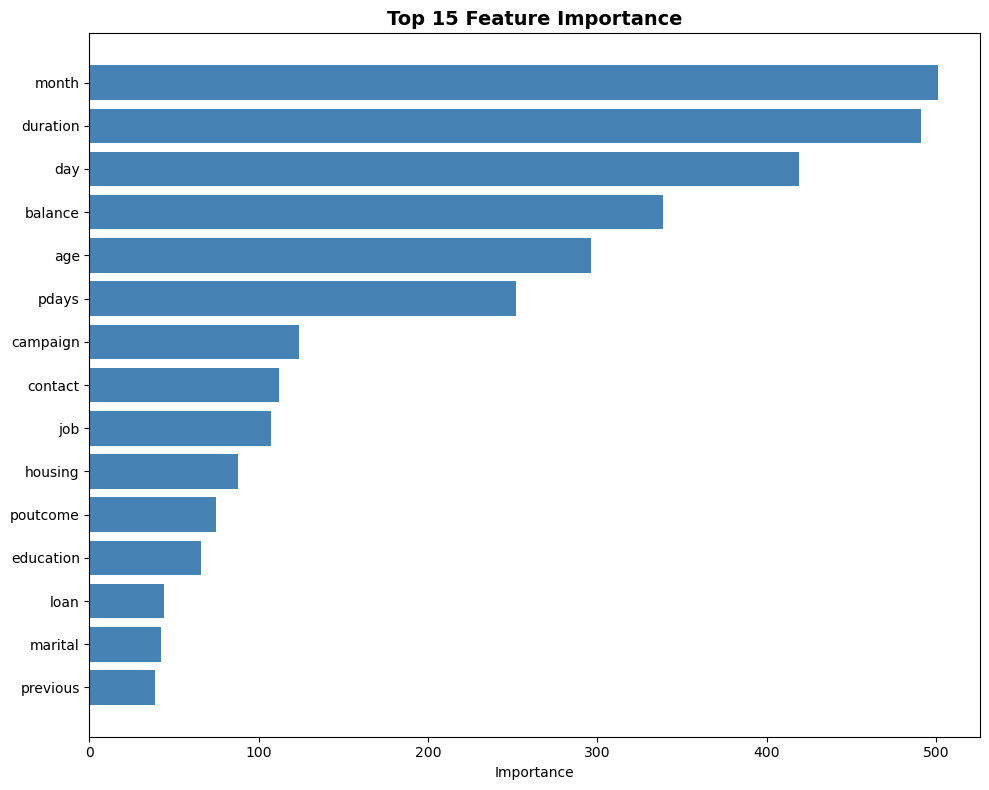

In [11]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print('=== TOP 10 FEATURE IMPORTANCE ===')
print(feature_importance.head(10).to_string(index=False))

# Feature Importance Grafigi
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 5. Baseline Model Sonuçları

### Cross-Validation Sonuçları
- **5-Fold CV AUC:** 0.9239 (+/- 0.0056)
- Tüm fold'larda tutarlı performans

### Test Seti Sonuçları
- **AUC:** 0.9259
- **Accuracy:** 0.8607 (%86.07)
- **Precision:** 0.8297
- **Recall:** 0.8885
- **F1 Score:** 0.8581

### En Önemli Feature'lar
1. **month** (501) - Mevsimsellik etkisi
2. **duration** (491) - ⚠️ **Production'da kullanılamaz!**
3. **day** (419) - Ayın günü
4. **balance** (339) - Müşteri bakiyesi
5. **age** (296) - Müşteri yaşı

### Önemli Notlar
- Baseline model zaten çok iyi performans gösteriyor (AUC ~0.92)
- `duration` feature'i en önemli feature'lardan biri ama **gerçekçi bir production modeli için çıkarılmalı**
- Feature engineering ile daha da iyileştirilebilir

### Sonraki Adımlar
1. **Feature Engineering** (03_feature_engineering.ipynb)
   - Yas grupları
   - Bakiye kategorileri
   - Mevsimsellik feature'ları
   - `duration` feature'ini çıkararak yeni baseline

2. **Model Optimizasyonu** (04_model_optimization.ipynb)
   - Hiperparametre optimizasyonu
   - Model karşılaştırması

## 3. Baseline Model

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
# scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
# print(f'Baseline AUC: {scores.mean():.4f}')

## 4. Sonuclar

- Baseline AUC: X.XXXX
- Sonraki adim: Feature Engineering